In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from atusfunclib import load_data

In [78]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn import model_selection

In [4]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [5]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [6]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [7]:
df.filter(regex=r'TUCASEID|^t.+[^W]$').head()

,TUCASEID,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t09,t10,t11,t12,t13,t14,t15,t16,t18,t50
0,20030100013280,870,0,0,40,0,0,0,0,0,...,0,0,5,325,200,0,0,0,0,0
1,20030100013344,620,0,0,60,0,0,0,0,0,...,0,0,90,590,0,0,0,0,20,0
2,20030100013352,560,0,0,80,0,0,0,0,0,...,0,0,75,340,0,0,0,60,10,0
3,20030100013848,720,0,0,35,0,0,0,0,0,...,0,0,25,265,0,0,0,0,0,0
4,20030100014165,385,0,0,75,0,0,0,0,0,...,0,0,92,60,60,0,0,0,78,0


In [8]:
df.filter(regex=r'^[^t]').head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,TRERNHLY,TRERNWA,TRERNWA_CAT,GESTFIPS,TEHRUSLT_W,TEAGE_W,TRCHILDNUM_W,TRNUMHOU_W,TRERNHLY_W,TRERNWA_W
0,20030100013280,60,1,2003,0,6,1.0,NaN,30.0,2,...,22.0,660.0,4.0,6,2.446639e+08,4.893278e+08,0.000000e+00,2.446639e+07,1.794202e+08,5.382605e+09
1,20030100013344,41,2,2003,0,7,2.0,NaN,30.0,1,...,NaN,200.0,1.0,6,5.205968e+07,7.114822e+07,3.470645e+06,6.941290e+06,NaN,3.470645e+08
2,20030100013352,26,2,2003,0,7,1.0,NaN,12.0,2,...,12.5,200.0,1.0,6,4.596633e+07,9.959371e+07,0.000000e+00,7.661055e+06,4.788159e+07,7.661055e+08
3,20030100013848,36,2,2003,0,5,2.0,NaN,NaN,4,...,NaN,NaN,NaN,13,NaN,2.383928e+08,1.324405e+07,2.648809e+07,NaN,NaN
4,20030100014165,51,1,2003,0,5,2.0,NaN,80.0,1,...,NaN,NaN,NaN,21,2.454710e+08,1.564878e+08,6.136775e+06,1.227355e+07,NaN,NaN


In [9]:
# Activities that we are interested in
positiveWL = ['010101', '0102', '0103', '050201',
              '050203', '1101', '1201', '1202',
              '1203', '1204', '1301', '1302', '14']

negoccWL = ['05', '0501', '0504', '1805']

neghomeWL = ['0201', '0202', '0203', '0204', '0209',
             '0301', '0302', '0303', '0304', '0305',
             '0802', '0803']

neutral = ['06', '07', '09', '18']

activities = positiveWL + negoccWL + neghomeWL + neutral

activities_c = ['t'+ a for a in activities]

In [104]:
# Activity names dictionary
activities_dict = dict(zip(dfactcodes.CODE, dfactcodes.NAME))

In [10]:
def clusterOptimizer(X, prescale=1.0, nc=range(3, 16), batch_size=20000, sample_size=5000):
    X = X / prescale
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    print "{} samples, {} features".format(*X_scaled.shape)
    
    ss = []
    for n in nc:
        k_means_activity = MiniBatchKMeans(n_clusters=n, batch_size=batch_size)
        k_means_activity.fit(X_scaled)
        y = k_means_activity.predict(X_scaled)
        sindex = metrics.silhouette_score(X_scaled, y, sample_size=sample_size)
        chindx = metrics.calinski_harabaz_score(X_scaled, y)
        ss.append(sindex)
        print "  for {:2d} clusters, S={}, CH={}".format(n, sindex, chindx)
        
    nc_optimum = nc[np.argmax(ss)]
        
    print "optimum clusters = {}".format(nc_optimum)

    k_means_activity_opt = MiniBatchKMeans(n_clusters=nc_optimum, batch_size=batch_size)
    k_means_activity_opt.fit(X_scaled)
    y_opt = k_means_activity_opt.predict(X_scaled)
    sindex = metrics.silhouette_score(X_scaled, y_opt, sample_size=sample_size)
    chindx = metrics.calinski_harabaz_score(X_scaled, y_opt)
    
    print "metrics:"
    print "  silhouette score         {}".format(sindex)
    print "  calinski-harabaz index   {}".format(chindx)
    
    result = scaler.inverse_transform(k_means_activity_opt.cluster_centers_) * prescale
    
    return result, ss

In [53]:
# Clustering activity times with MiniBatchKMeans

In [29]:
PRESCALE = 10.0

X_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)][activities_c]
X_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)][activities_c]

In [30]:
result_wehol, ss_wehol = clusterOptimizer(X_wehol,
                                          prescale=PRESCALE,
                                          nc=range(4, 10),
                                          batch_size=10000,
                                          sample_size=10000)

87293 samples, 33 features
  for  4 clusters, S=0.0741758211947, CH=3873.79963968
  for  5 clusters, S=0.16998378152, CH=3569.27930271
  for  6 clusters, S=0.0603064573991, CH=3357.59271459
  for  7 clusters, S=0.109963558784, CH=3178.10479356
  for  8 clusters, S=0.099262766816, CH=3265.21915021
  for  9 clusters, S=0.0849174934795, CH=3097.42681956
optimum clusters = 5
metrics:
  silhouette score         0.156890907458
  calinski-harabaz index   3378.60195023


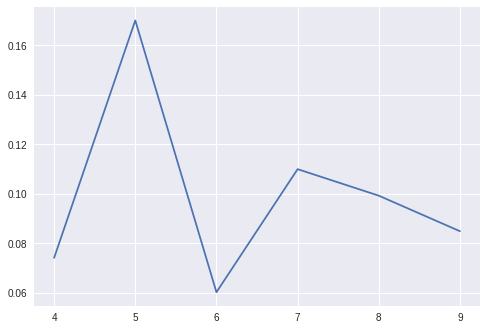

In [32]:
plt.plot(range(4, 10), ss_wehol)

In [33]:
result_df_wehol = pd.DataFrame(result_wehol, columns=activities_c)

In [54]:
pd.options.display.float_format = '{:.4f}'.format
result_df_wehol[["t"+a for a in positiveWL]]

,t010101,t0102,t0103,t050201,t050203,t1101,t1201,t1202,t1203,t1204,t1301,t1302,t14
0,526.8862,32.3141,1.2456,0.0073,-0.0000,76.8594,46.1560,11.5549,150.4892,2.8196,32.7923,2.3122,15.1768
1,575.4892,37.1463,6.8971,0.0307,0.0014,66.3678,56.9483,12.0936,316.5763,0.9609,19.4408,3.1588,24.9731
2,541.4699,36.1051,0.4134,0.0000,-0.0000,64.3176,32.5792,7.3181,142.6418,4.8449,16.6338,1.8122,14.5222
3,510.9688,47.7461,1.2879,0.0000,-0.0000,135.1672,50.0525,5.5705,148.6434,121.4706,24.3801,5.5449,11.8926
4,474.6615,48.0079,0.8598,0.3264,0.0265,59.6467,37.5439,7.7285,136.3590,2.4219,11.2154,2.2156,9.8872


In [35]:
result_df_wehol[["t"+a for a in negoccWL]]

,t05,t0501,t0504,t1805
0,15.7043,13.7651,0.9706,0.8221
1,8.8273,7.2417,0.4922,0.5342
2,19.6749,17.8300,0.8407,1.4517
3,15.3348,13.7388,0.3349,1.0924
4,432.5231,423.5584,1.5799,34.0086


In [36]:
result_df_wehol[["t"+a for a in neghomeWL]]

,t0201,t0202,t0203,t0204,t0209,t0301,t0302,t0303,t0304,t0305,t0802,t0803
0,56.6217,60.4318,5.9158,2.6581,12.5258,222.5854,6.7621,4.1928,0.3029,0.7346,0.1480,-0.0000
1,53.0832,40.3470,7.4472,6.0592,13.8146,7.5875,0.6079,0.2276,0.9448,0.6221,0.2503,0.0124
2,24.7697,22.2658,1.2518,0.2032,6.1794,15.2032,0.2149,0.5582,0.3965,0.2975,0.3835,0.0000
3,30.9347,20.2643,4.6134,2.0487,15.0117,13.3757,0.4610,0.1139,0.1843,1.2501,0.2736,0.0000
4,19.1534,17.6705,2.6725,1.0324,7.3530,11.9841,0.5465,0.2169,0.2679,0.5636,0.1748,0.0005


In [37]:
result_df_wehol[["t"+a for a in neutral]]

,t06,t07,t09,t18
0,1.9708,33.3178,0.5502,65.8008
1,3.1278,34.3382,0.7283,58.5817
2,372.2704,20.6441,0.1098,55.0967
3,3.0161,37.7341,0.6920,168.4102
4,2.9057,17.8301,0.5022,92.4557


In [39]:
result_weday, ss_weday = clusterOptimizer(X_weday,
                                          prescale=PRESCALE,
                                          nc=range(4, 11),
                                          batch_size=10000,
                                          sample_size=10000)

83549 samples, 33 features
  for  4 clusters, S=0.132648814992, CH=3909.70741872
  for  5 clusters, S=0.159497767272, CH=3560.56711415
  for  6 clusters, S=0.0896098028158, CH=3252.15197921
  for  7 clusters, S=0.131965916622, CH=3225.67589687
  for  8 clusters, S=0.0883663136613, CH=3172.79602593
  for  9 clusters, S=0.165558754344, CH=3054.51071728
  for 10 clusters, S=0.0500209011073, CH=3079.55237571
optimum clusters = 9
metrics:
  silhouette score         0.162359834249
  calinski-harabaz index   3176.18925815


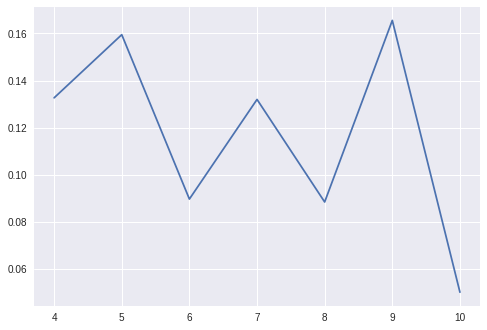

In [41]:
plt.plot(range(4, 11), ss_weday)

In [42]:
result_df_weday = pd.DataFrame(result_weday, columns=activities_c)

In [43]:
pd.options.display.float_format = '{:.4f}'.format
result_df_weday[["t"+a for a in positiveWL]]

,t010101,t0102,t0103,t050201,t050203,t1101,t1201,t1202,t1203,t1204,t1301,t1302,t14
0,498.7023,38.0234,1.7097,-0.0000,0.0000,62.4034,29.1415,13.4982,193.1181,4.9483,14.8856,0.1845,3.0480
1,469.2915,52.7395,3.9686,0.0485,0.0019,61.6130,66.6868,3.9093,156.3095,4.0236,7.9930,0.3507,2.5755
2,454.7948,46.3809,1.2909,0.0499,0.0587,61.0198,18.1346,1.6238,128.6466,2.1417,9.2599,0.2050,1.1313
3,520.2159,48.8657,5.7099,0.0000,0.0000,61.6343,38.3533,2.6145,181.2334,1.5484,8.6256,0.0722,135.9003
4,518.8996,36.7584,3.9646,-0.0000,-0.0000,61.8997,37.7712,3.8420,162.3469,4.6386,7.7064,0.2765,1.9762
5,556.7390,30.5979,16.5793,-0.0000,0.0000,59.2392,35.9326,1.4844,436.5839,2.3009,5.6355,0.1429,1.7741
6,455.1269,49.7286,0.2173,-0.0000,0.0000,56.5666,26.3957,2.1947,111.3329,2.5942,19.1382,177.5176,1.1369
7,517.4370,46.5843,1.9959,0.0000,0.0000,99.2565,45.2864,3.2510,161.2964,12.0343,96.6253,0.3583,1.6133
8,428.4630,43.2222,1.1111,178.5000,10.0000,46.8889,21.0926,1.1111,60.6852,0.5556,5.4630,5.0000,1.8704


In [44]:
result_df_weday[["t"+a for a in negoccWL]]

,t05,t0501,t0504,t1805
0,293.1993,23.6162,267.5080,33.1611
1,148.3898,144.4324,1.1497,13.6335
2,514.3416,511.5571,0.2190,42.2902
3,103.5430,100.4923,1.2592,8.0655
4,38.8257,36.2015,1.2106,2.7394
5,13.5768,10.9090,1.0026,1.1275
6,213.3392,211.9384,1.2374,14.6168
7,33.5798,31.1738,0.8557,2.5967
8,666.0741,461.1667,-0.0000,66.1296


In [45]:
result_df_weday[["t"+a for a in neghomeWL]]

,t0201,t0202,t0203,t0204,t0209,t0301,t0302,t0303,t0304,t0305,t0802,t0803
0,29.6974,34.5363,3.3506,1.2731,11.8733,32.7245,5.3444,0.8967,1.8942,0.8647,0.4649,0.3075
1,36.2289,47.6814,3.5662,2.9745,112.5952,19.2852,2.8466,0.9934,1.7411,0.5218,1.2528,0.1298
2,11.8192,19.5668,1.8818,1.2264,4.8637,20.7967,3.0143,0.4411,0.4604,0.3187,0.3461,0.0131
3,38.6800,38.9859,2.6830,3.5138,10.5393,18.7371,3.9161,0.8674,1.9312,12.6605,0.5336,0.0403
4,100.5271,68.0364,5.0018,2.5686,10.8047,98.6980,12.0546,4.0738,3.0994,0.8096,1.3206,0.1669
5,42.3657,35.0923,5.8081,6.4382,6.3511,5.4787,1.0597,0.1661,1.6471,0.3471,0.4932,0.0235
6,16.7864,15.8405,0.7915,1.4598,9.6482,15.8291,2.7374,0.2701,0.0063,0.2651,0.7073,0.0000
7,23.0794,33.2141,6.1948,2.4275,8.4926,26.1132,2.0168,0.5315,0.5968,0.4650,0.4728,0.0160
8,10.1111,14.3333,0.0000,0.0000,3.7222,6.6296,0.0000,-0.0000,-0.0000,0.2407,0.7407,0.0000


In [46]:
result_df_weday[["t"+a for a in neutral]]

,t06,t07,t09,t18
0,5.9028,16.9446,0.9779,86.1033
1,15.4838,18.5452,2.6744,104.5348
2,8.4970,9.6445,0.4730,81.1597
3,18.6921,18.7827,1.0917,82.5269
4,12.4962,71.2580,1.8406,87.7328
5,22.6666,10.9645,1.4733,38.2710
6,87.8015,13.0930,0.3769,114.6972
7,147.6075,13.2631,0.9833,79.7075
8,0.0000,18.9074,0.0370,91.7778


In [68]:
# Plot some examples of group activities

In [114]:
result_df_wehol_norm = pd.DataFrame(normalize(result_df_wehol, axis=0), columns=activities_c)
result_df_weday_norm = pd.DataFrame(normalize(result_df_weday, axis=0), columns=activities_c)

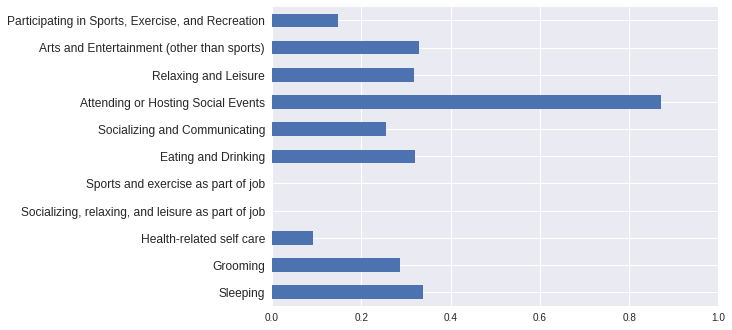

In [147]:
p = result_df_weday_norm[["t"+a for a in positiveWL[:-2]]].iloc[0].plot(kind='barh')
p.set_yticklabels([activities_dict[a] for a in positiveWL[:-2]], fontsize=12)
p.set(xlim=[0,1])
plt.savefig('fig_group0_pos.svg', bbox_inches='tight')
plt.show()

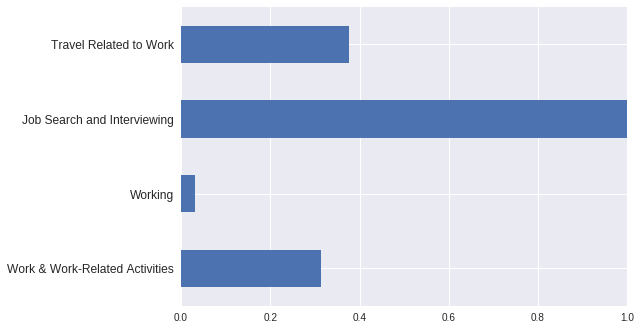

In [134]:
p = result_df_weday_norm[["t"+a for a in negoccWL]].iloc[0].plot(kind='barh')
p.set_yticklabels([activities_dict[a] for a in negoccWL], fontsize=12)
p.set(xlim=[0,1])
plt.savefig('fig_group0_neg.svg', bbox_inches='tight')
plt.show()

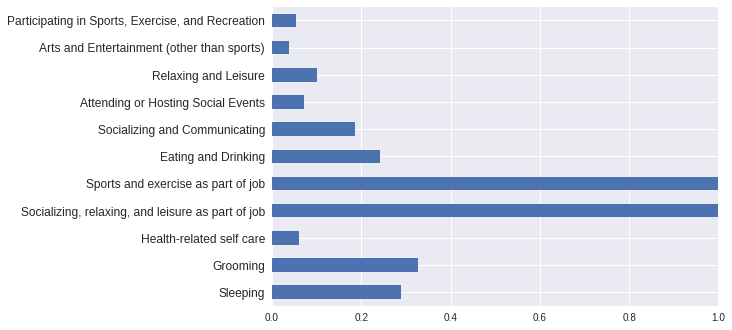

In [135]:
p = result_df_weday_norm[["t"+a for a in positiveWL[:-2]]].iloc[8].plot(kind='barh')
p.set_yticklabels([activities_dict[a] for a in positiveWL[:-2]], fontsize=12)
p.set(xlim=[0,1])
plt.savefig('fig_group8_pos.svg', bbox_inches='tight')
plt.show()

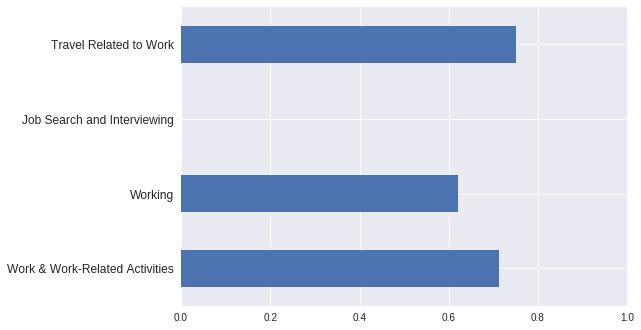

In [136]:
p = result_df_weday_norm[["t"+a for a in negoccWL]].iloc[8].plot(kind='barh')
p.set_yticklabels([activities_dict[a] for a in negoccWL], fontsize=12)
p.set(xlim=[0,1])
plt.savefig('fig_group8_neg.svg', bbox_inches='tight')
plt.show()